# 自然语言处理：应用

前面我们学习了如何在文本序列中表示词元，并在14章中训练了词元的表示。这样的预训练文本表示可以通过不同模型架构，放入不同的下游自然语言处理任务。

前一章我们提及到一些自然语言处理应用，这些应用没有预训练，只是为了解释深度学习架构。例如，在14.8节中，我们依赖循环神经网络设计语言模型来生成类似中篇小说的文本。在14.9节和14.10节中，我们还设计了基于循环神经网络和注意力机制的机器翻译模型。

然而，本书并不打算全面涵盖所有此类应用。相反，我们的重点是**如何应用深度语言表征学习来解决自然语言处理问题**。在给定预训练的文本表示的情况下，本章将探讨两种流行且具有代表性的下游自然语言处理任务：情感分析和自然语言推断，它们分别分析单个文本和文本对之间的关系。

![预训练文本表示可以通过不同模型架构，放入不同的下游自然语言处理应用（本章重点介绍如何为不同的下游应用设计模型）](../img/14_8.png)

如上图所述，本章将重点描述然后使用不同类型的深度学习架构（如多层感知机、卷积神经网络、循环神经网络和注意力）设计自然语言处理模型。尽管在上图中，可以将任何预训练的文本表示与任何应用的架构相结合，但我们选择了一些具有代表性的组合。具体来说，我们将探索基于循环神经网络和卷积神经网络的流行架构进行情感分析。对于自然语言推断，我们选择注意力和多层感知机来演示如何分析文本对。最后，我们介绍了如何为广泛的自然语言处理应用，如在序列级（单文本分类和文本对分类）和词元级（文本标注和问答）上对预训练BERT模型进行微调。作为一个具体的经验案例，我们将针对自然语言推断对BERT进行微调。

正如我们在14.8节中介绍的那样，对于广泛的自然语言处理应用，BERT只需要最少的架构更改。然而，这一好处是以微调下游应用的大量BERT参数为代价的。当空间或时间有限时，基于多层感知机、卷积神经网络、循环神经网络和注意力的精心构建的模型更具可行性。下面，我们从情感分析应用开始，分别解读基于循环神经网络和卷积神经网络的模型设计。

# 15.1. 情感分析及数据集

随着在线社交媒体和评论平台的快速发展，大量评论的数据被记录下来。这些数据具有支持决策过程的巨大潜力。**情感分析**（sentiment analysis）研究人们在文本中（如产品评论、博客评论和论坛讨论等）“隐藏”的情绪。它在广泛应用于政治（如公众对政策的情绪分析）、金融（如市场情绪分析）和营销（如产品研究和品牌管理）等领域。

由于情感可以被分类为**离散的极性或尺度**（例如，积极的和消极的），我们可以将情感分析看作一项文本分类任务，它将可变长度的文本序列转换为固定长度的文本类别。在本章中，我们将使用斯坦福大学的[大型电影评论数据集（large movie review dataset）](https://ai.stanford.edu/~amaas/data/sentiment/)进行情感分析。它由一个训练集和一个测试集组成，其中包含从IMDb下载的25000个电影评论。在这两个数据集中，“积极”和“消极”标签的数量相同，表示不同的情感极性。

## 15.1.1. 读取数据集

In [1]:
import os
import torch
from torch import nn
from d2l import torch as d2l

"""
首先，下载并提取路径../data/aclImdb中的IMDb评论数据集。
"""
#@save
d2l.DATA_HUB['aclImdb']=('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz','01ada507287d82875905620988597833ad4e0903')

data_dir=d2l.download_extract('aclImdb','aclImdb')

"""
接下来，读取训练和测试数据集。每个样本都是一个评论及其标签：1表示“积极”，0表示“消极”。
"""
#@save
def read_imdb(data_dir,is_train):
    """读取IMDb评论数据集文本序列和标签"""
    data,labels=[],[]
    for label in ('pos','neg'):
        folder_name=os.path.join(data_dir,'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name,file),'rb' ) as f:
                review=f.read().decode('utf-8').replace('\n','')
                data.append(review)
                labels.append(1 if label=='pos' else 0)
    return data,labels

train_date=read_imdb(data_dir,is_train=True)
print('训练集数目：',len(train_date[0]))
for x,y in zip(train_date[0][:3],train_date[1][:3]):
    print('标签：',y,' review:',x[0:60])

训练集数目： 25000
标签： 1  review: I loved this mini series. Tara Fitzgerald did an incredible 
标签： 1  review: Caught this film in about 1990 on video by chance and withou
标签： 1  review: The film exposes the blatant exploitation of the Chinese wor


## 15.1.2. 预处理数据集

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <BarContainer object of 19 artists>)

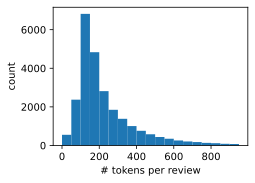

In [2]:
"""
将每个单词作为一个词元，过滤掉出现不到5次的单词，我们从训练数据集中创建一个词表。
"""
train_tokens=d2l.tokenize(train_date[0],token='word')
vocab=d2l.Vocab(train_tokens,min_freq=5,reserved_tokens=['<pad>'])

"""
在词元化之后，让我们绘制评论词元长度的直方图。
"""
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens],bins=range(0,1000,50))

In [3]:
"""
正如我们所料，评论的长度各不相同。为了每次处理一小批量这样的评论，我们通过截断和填充将每个评论的长度设置为500。这类似于 9.5节中对机器翻译数据集的预处理步骤。
"""
num_steps=500  # 序列长度
train_features=torch.tensor([d2l.truncate_pad(
    vocab[line],num_steps,vocab['<pad>']) for line in train_tokens])
train_features.shape


torch.Size([25000, 500])

## 15.1.3. 创建数据迭代器

In [4]:
"""
现在我们可以创建数据迭代器了。在每次迭代中，都会返回一小批量样本。
"""
train_iter=d2l.load_array((train_features,torch.tensor(train_date[1])),64)

for X,y in train_iter:
    print('X:',X.shape,',y:',y.shape)
    break
print('小批量数目：',len(train_iter))

X: torch.Size([64, 500]) ,y: torch.Size([64])
小批量数目： 391


## 15.1.4. 整合代码

In [5]:
"""
最后，我们将上述步骤封装到load_data_imdb函数中。它返回训练和测试数据迭代器以及IMDb评论数据集的词表。
"""
#@save
def load_data_imbd(batch_size,num_steps=500):
    """"""
    data_dir=d2l.download_extract('acImdb','aclImdb')
    train_data=read_imdb(data_dir,True)
    test_data=read_imdb(data_dir,False)

    train_tokens=d2l.tokenize(train_data[0],token='word')
    test_tokens=d2l.tokenize(test_data[0],token='word')

    vocab=d2l.Vocab(train_tokens,min_freq=5)

    train_features=torch.tensor([d2l.truncate_pad(
        vocab[line],num_steps,vocab['<pad>']) for line in train_tokens])

    test_features=torch.tensor([d2l.truncate_pad(
        vocab[line],num_steps,vocab['<pad>']) for line in test_data])

    train_iter=d2l.load_array(
        (train_features,torch.tensor(train_data[1])),
        batch_size)

    test_iter=d2l.load_array(
        (test_features,torch.tensor(test_data[1])),
        batch_size,
        is_train=False)

    return train_iter,test_iter,vocab

## 15.1.5. 小结
* 情感分析研究人们在文本中的情感，这被认为是一个文本分类问题，它将可变长度的文本序列进行转换转换为固定长度的文本类别。
* 经过预处理后，我们可以使用词表将IMDb评论数据集加载到数据迭代器中